In [1]:
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
from scipy import stats
import pandas as pd

sns.set_style("whitegrid")  # 白色背景+浅灰色网格
plt.rcParams.update({
    'font.family': 'Arial',  # 推荐使用Arial/Helvetica/Times New Roman
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.dpi': 300
})

models = ["DQN", "DDQN", "DuelingDQN"]
makers = ['o', 'x', '^']
colors = ['blue', 'orange', "red"]
indicator = {}

# 读取数据
for model in  models:
    indicator[model] = {'score_mean':[], 'score_std':[], 'score_high': [], 'reward_mean': [], 'reward_std': [], 'evaulate_score': [], 'evaulate_reward': []}
    with open(f'./results/{model}/record.txt', 'r') as f:
        data = f.readlines()
        for line in data:
            score = line.strip('\n').split(' ')
            score = [float(s) for s in score]
            indicator[model]['score_mean'].append(score[0])
            indicator[model]['score_std'].append(score[1])
            indicator[model]['score_high'].append(score[2])
            indicator[model]['reward_mean'].append(score[3])
            indicator[model]['reward_std'].append(score[4])
    
    with open(f'./results/{model}/evaluate.txt', 'r') as f:
        data = f.readlines()
        for line in data:
            detail = line.strip('\n').split(' ')
            detail = [float(s) for s in detail]
            indicator[model]['evaulate_score'].append(detail[0])
            indicator[model]['evaulate_reward'].append(detail[1])
    
    indicator[model] = {key: np.array(indicator[model][key][:100]) for key in indicator[model].keys()}


# 读取human和random数据
df = pd.read_csv('./results/human.csv')
indicator['RANDOM'] = {'evaulate_score': np.array([float(s) for s in df.iloc[0]['scores'].split(' ')])}
indicator['HUMAN'] = {'evaulate_score': np.array([float(s) for s in df.iloc[1]['scores'].split(' ')])}

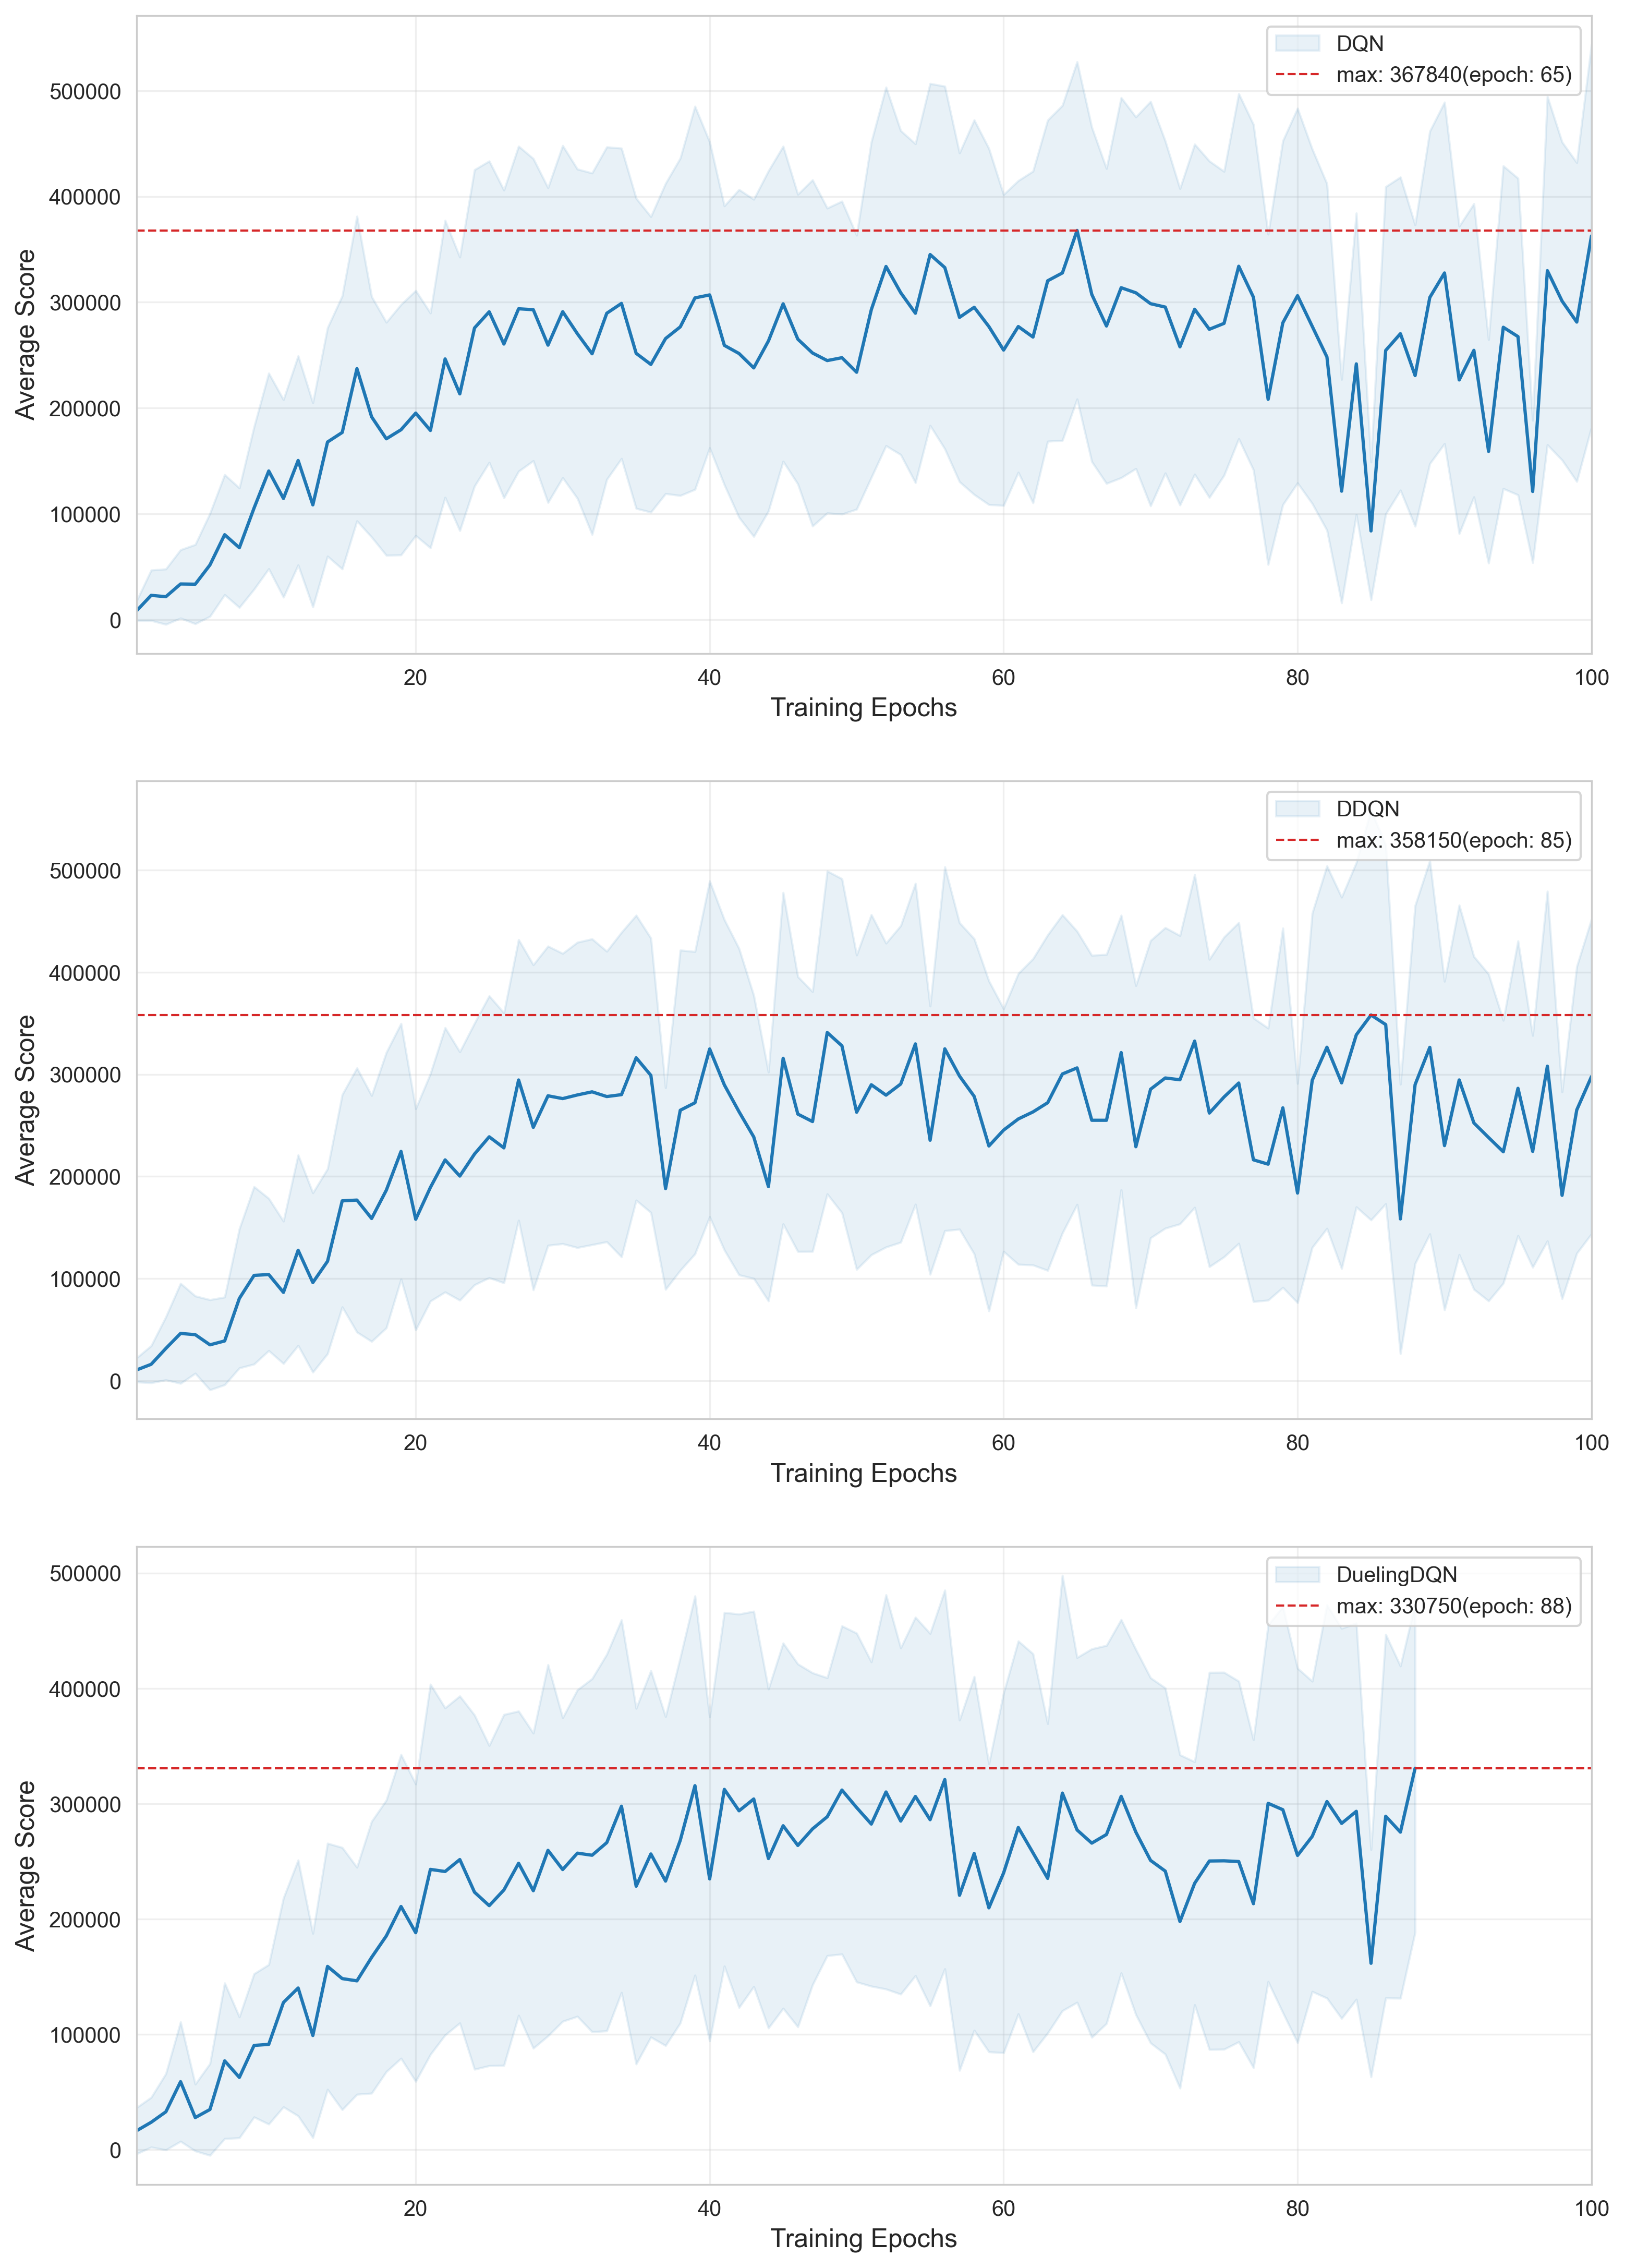

In [7]:
plt.figure(figsize=(12, 6*len(models)))
for i, model in enumerate(models):
    color = '#1f77b4'
    plt.subplot(len(models), 1, i+1)
    mean = indicator[model]['score_mean']
    std = indicator[model]['score_std']
    # 均分
    plt.plot(np.arange(1, len(mean)+1), mean, color=color)
    # 标准差
    plt.fill_between(np.arange(1, len(mean)+1), 
                     mean - std,
                     mean + std,
                     alpha=0.1, label=model, color=color)
    # 最高分
    max_epoch = np.argmax(mean) + 1
    max_value = int(np.max(mean))
    # 绘制最高分横线
    plt.axhline(y=max_value, color='#d62728', linestyle='--', linewidth=1, label=f'max: {max_value}(epoch: {max_epoch})')


    plt.ylabel("Average Score")
    plt.xlabel("Training Epochs")
    plt.legend(loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 100)

plt.savefig('./pictures/00_training_flctuatation.png', dpi=300, bbox_inches='tight')
plt.show()

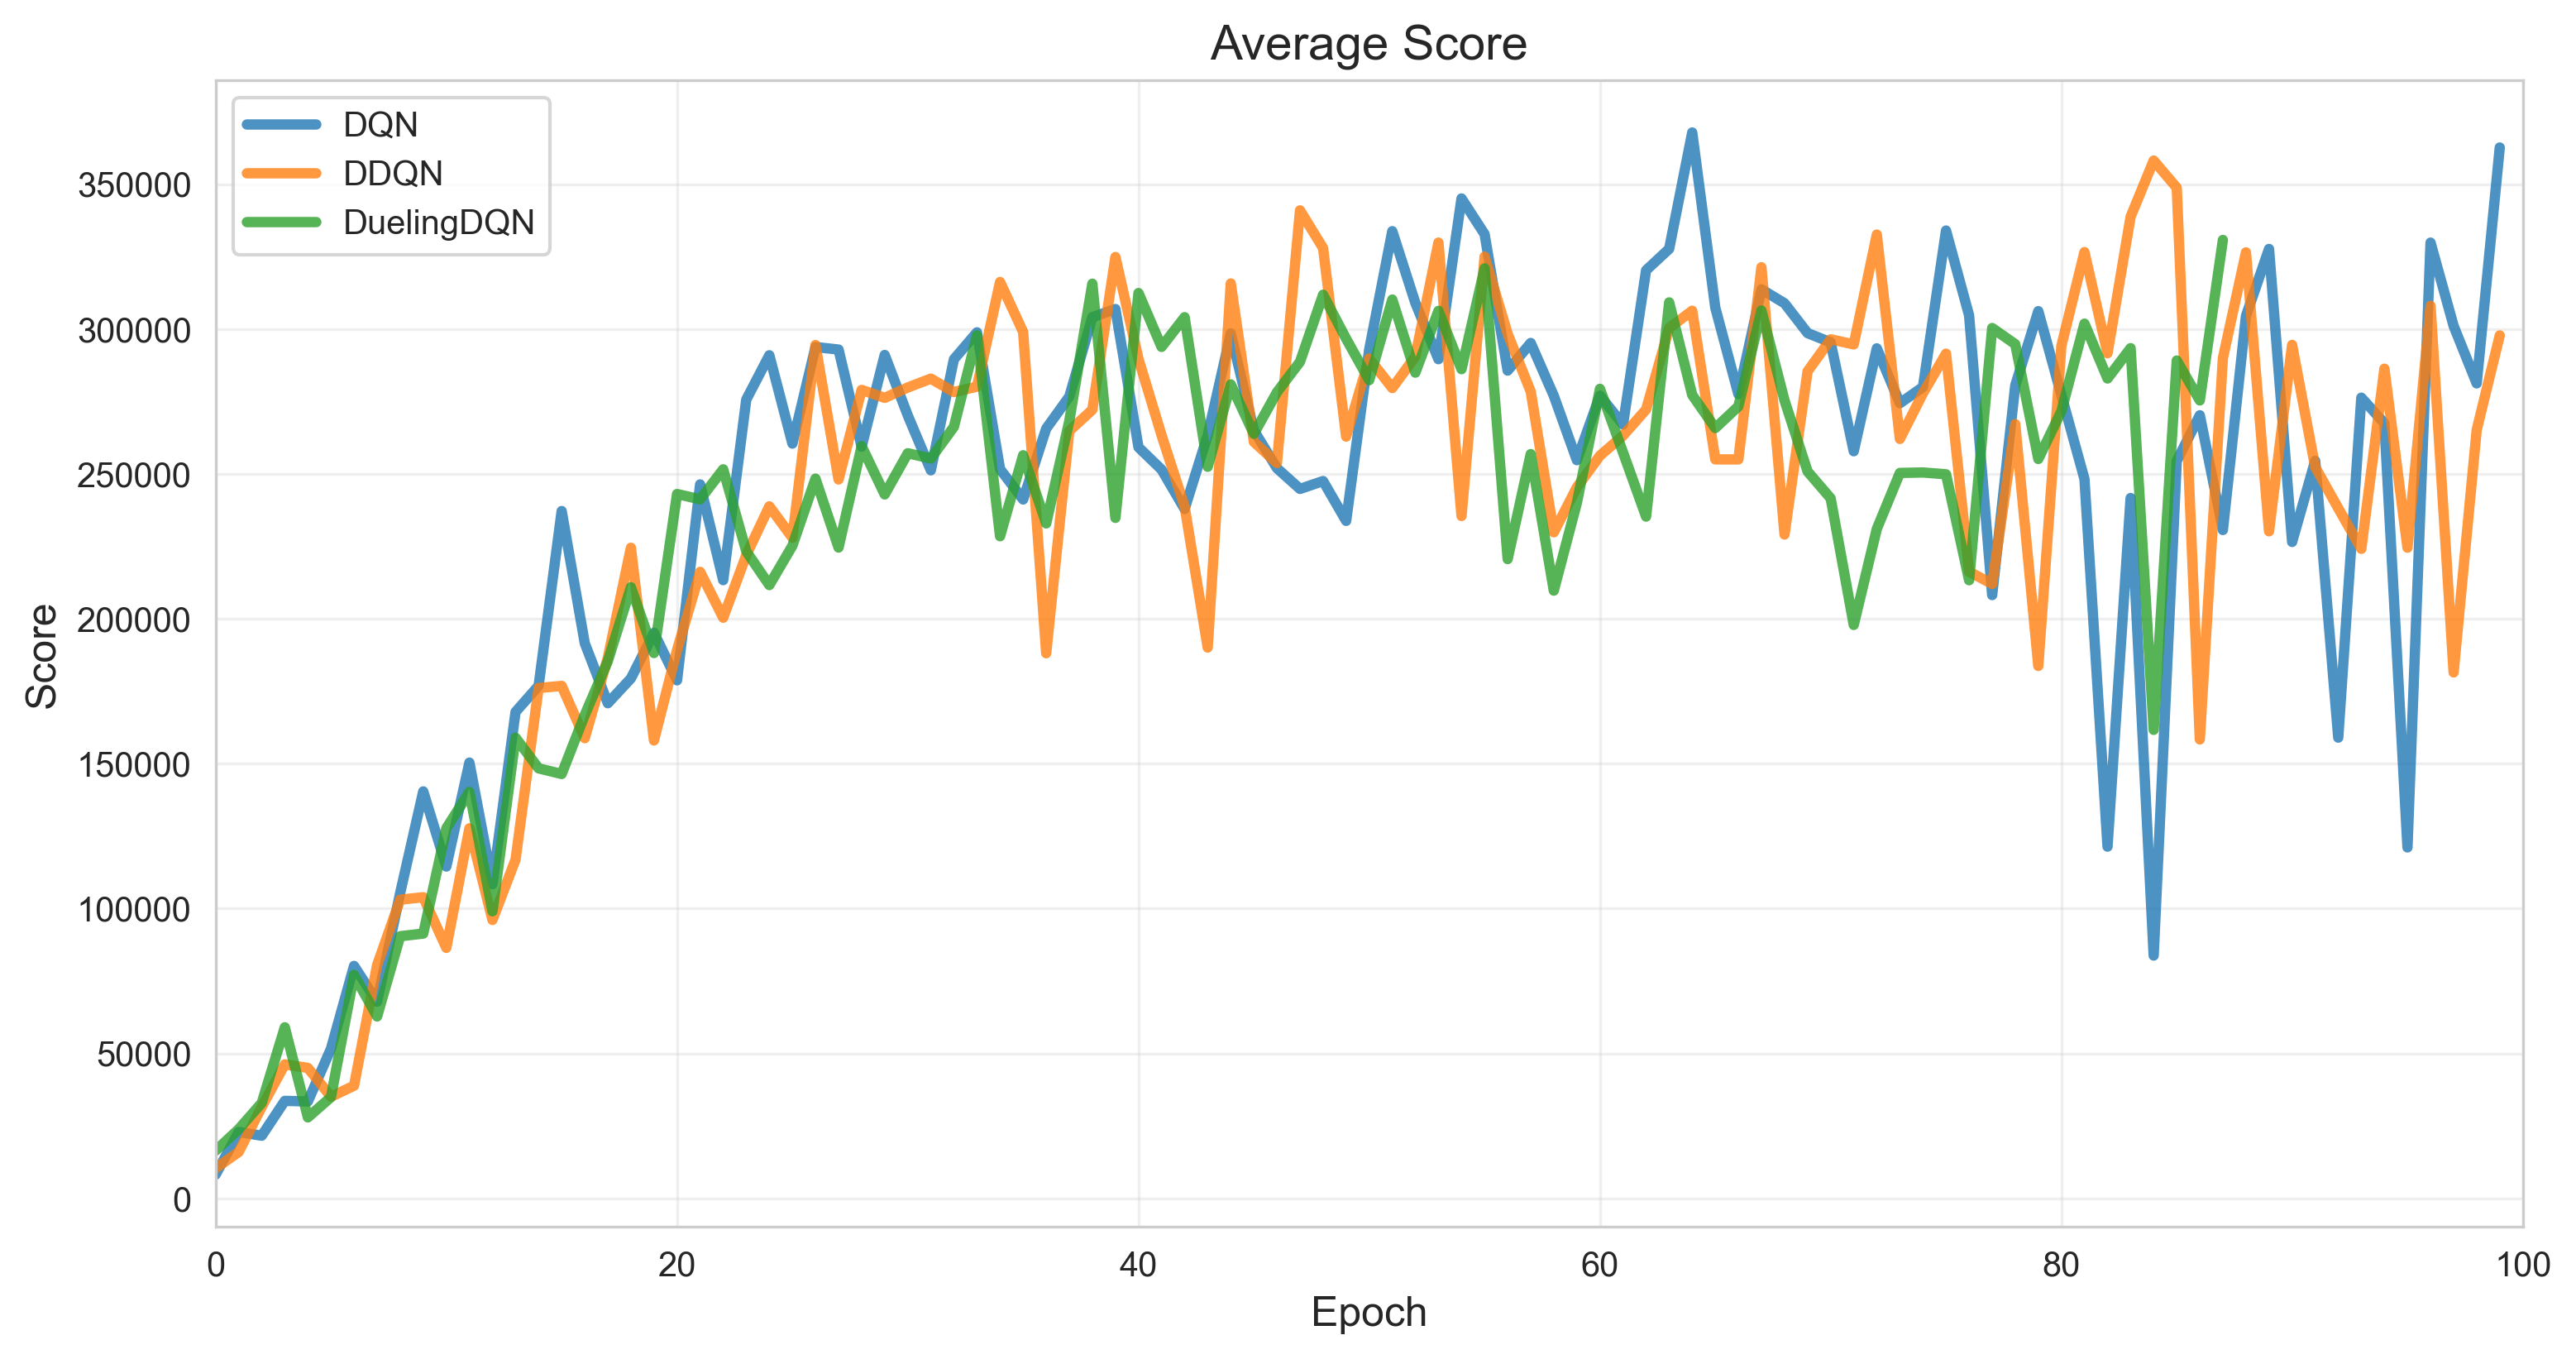

In [18]:
# 绘制图像
plt.figure(figsize=(12, 6))

colors = ['#1F77B4', '#FF7F0E', '#2CA02C']
for model, maker, c in zip(models, makers, colors):
    plt.plot(indicator[model]['score_mean'],
             label=model, 
            #  marker=maker,
             color = c,
            #  markersize=6,
             linewidth=3,
             alpha=0.8)
plt.xlim(0, 100)

plt.xlabel('Epoch')
plt.ylabel('Score')
plt.title("Average Score")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left')
plt.savefig('./pictures/01_training_score.png', dpi=300, bbox_inches='tight')
plt.show()

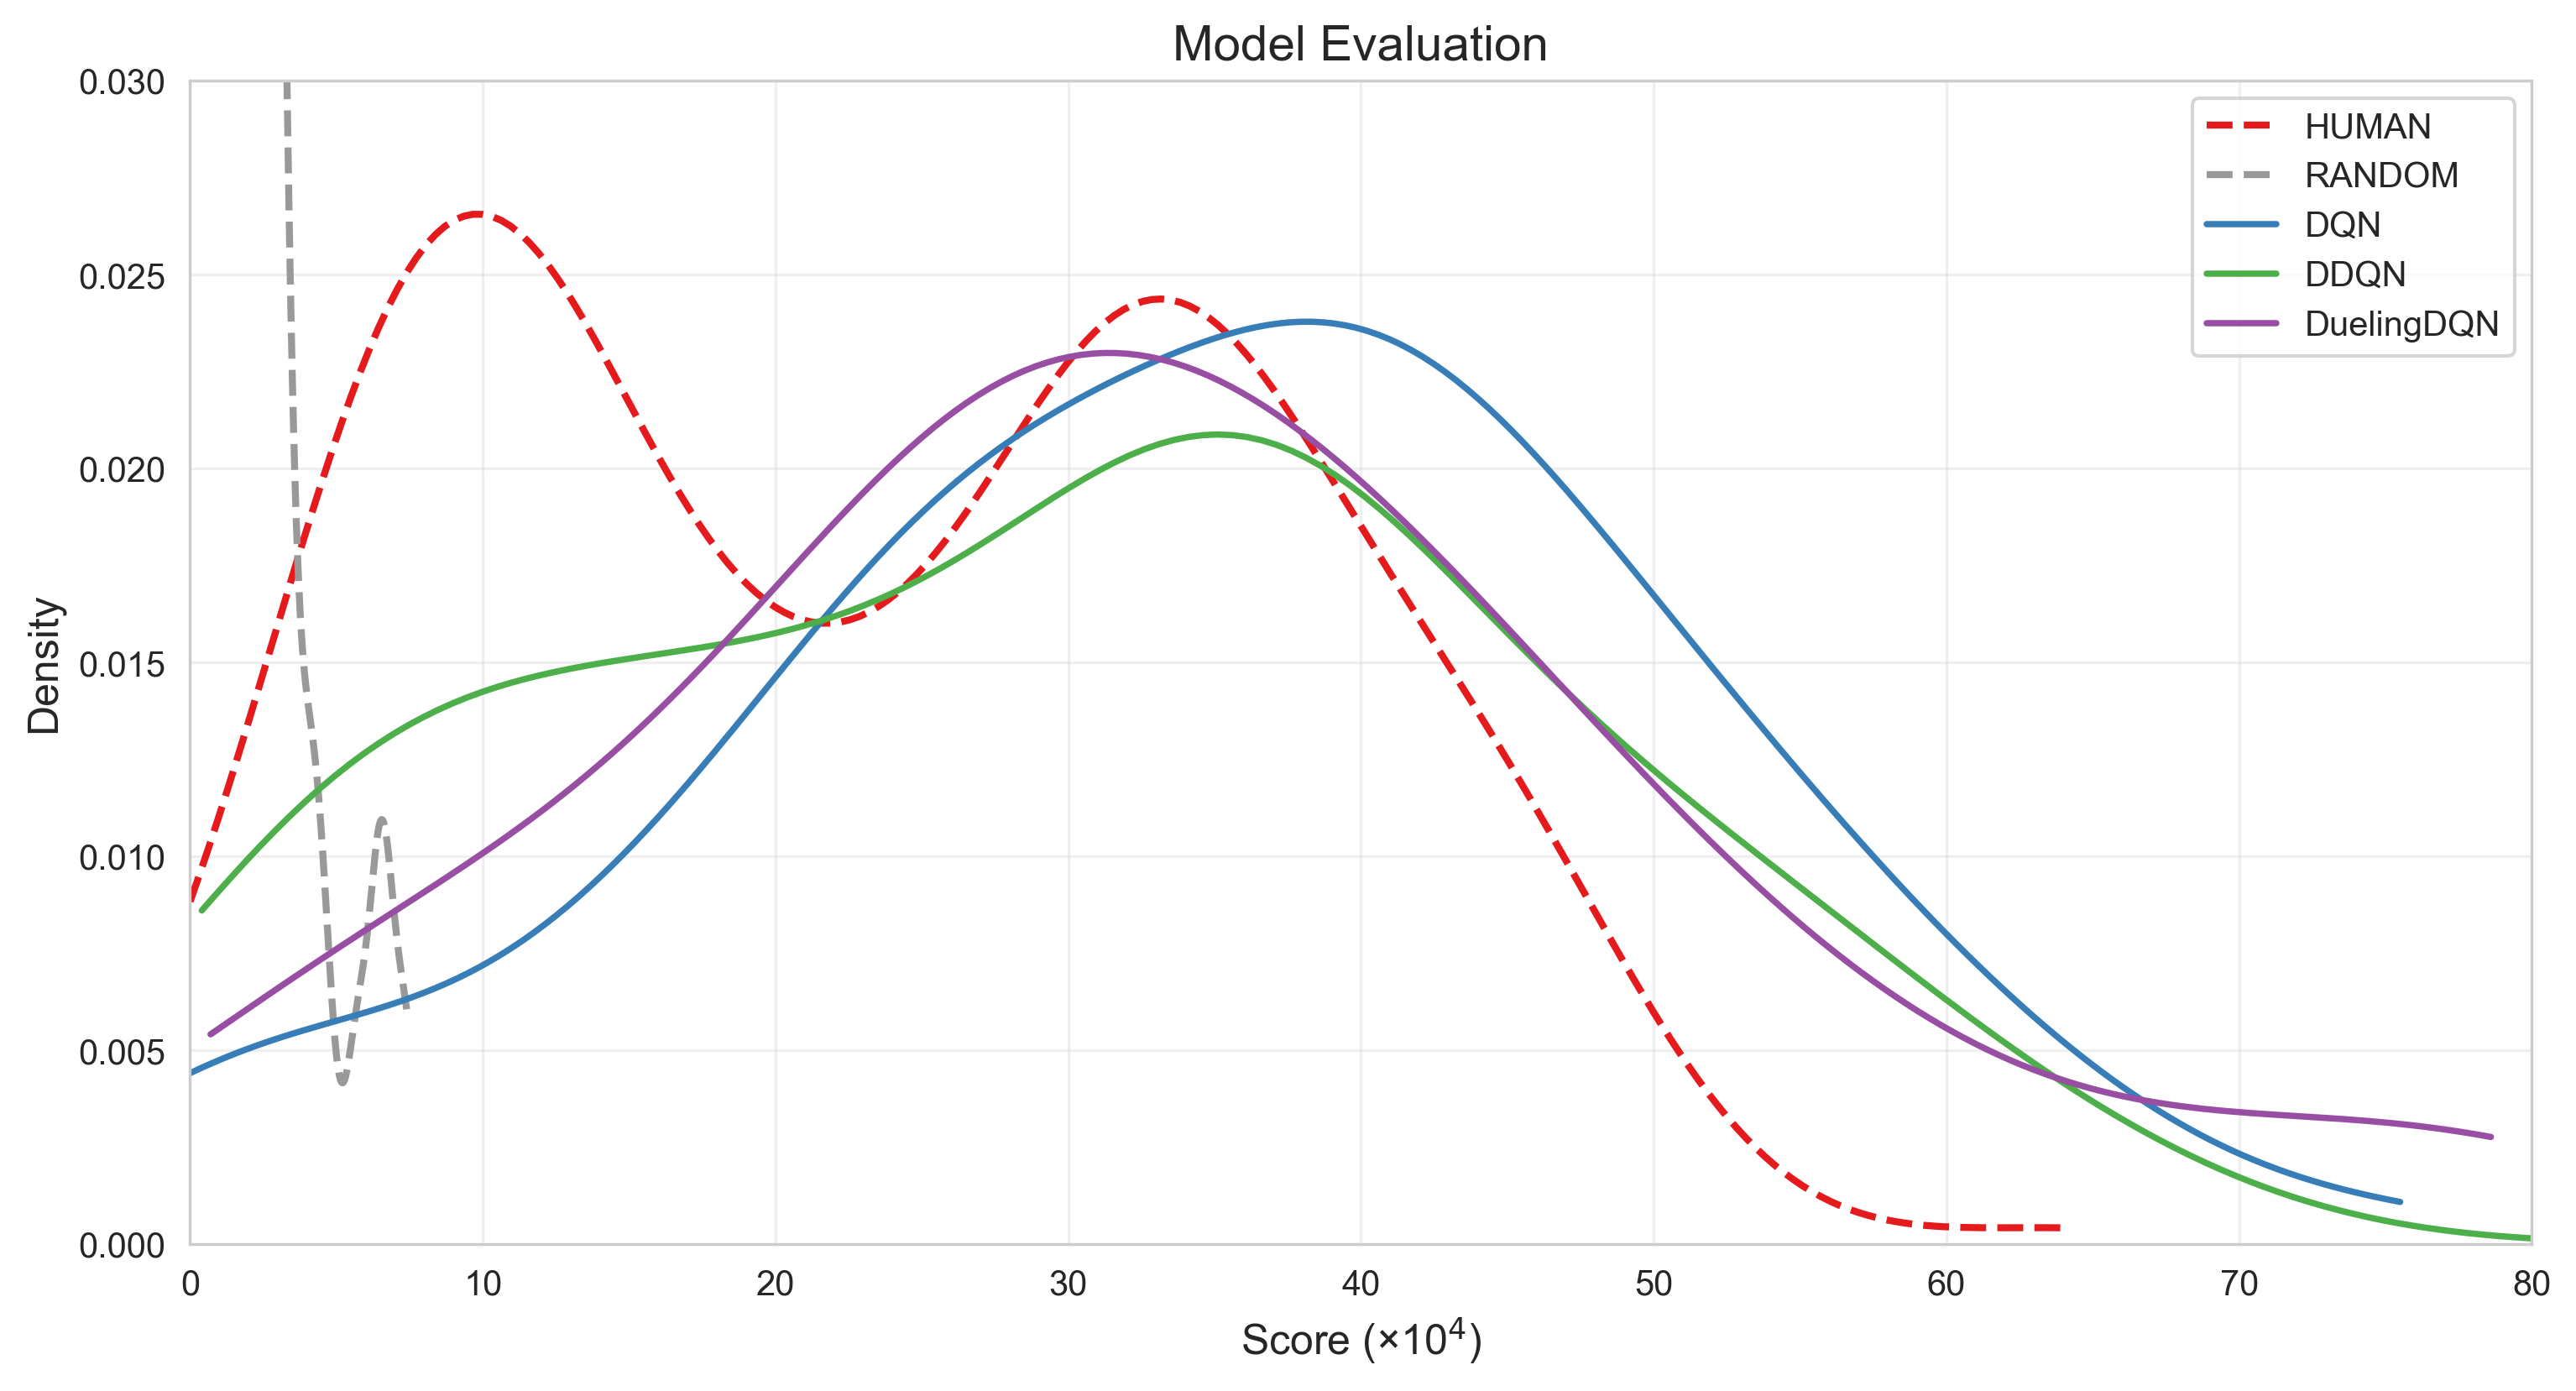

In [19]:
colors = {
    'HUMAN': '#E41A1C',  # 红色
    'RANDOM': '#999999', # 灰色
    'DQN': '#377EB8', # 蓝色
    'DDQN': '#4DAF4A', # 绿色
    'DuelingDQN': '#984EA3'  # 紫色
}
# 绘制密度曲线
line_styles = {'HUMAN': '--', 'RANDOM': '--', **{m: '-' for m in models}}
line_widths = {'HUMAN': 2, 'RANDOM': 2, **{m: 1.8 for m in models}}

plt.figure(figsize=(12, 6))
for model in ['HUMAN', 'RANDOM'] + models:
    score = indicator[model]['evaulate_score'] / 10000
    density = stats.gaussian_kde(score)
    xs = np.linspace(min(score), max(score), 200)
    plt.plot(xs, density(xs), 
             label = f'{model}',
             color=colors[model],
             linestyle=line_styles[model],
             linewidth=line_widths[model])

plt.title('Model Evaluation')
plt.legend(loc='upper right')
plt.xlabel('Score (×10$^4$)')
plt.ylabel('Density')
plt.grid(True, alpha=0.3)
plt.ylim(0, 0.03)
plt.xlim(0, 80)
plt.savefig('./pictures/02_evaluate.png', dpi=300, bbox_inches='tight')
plt.show()

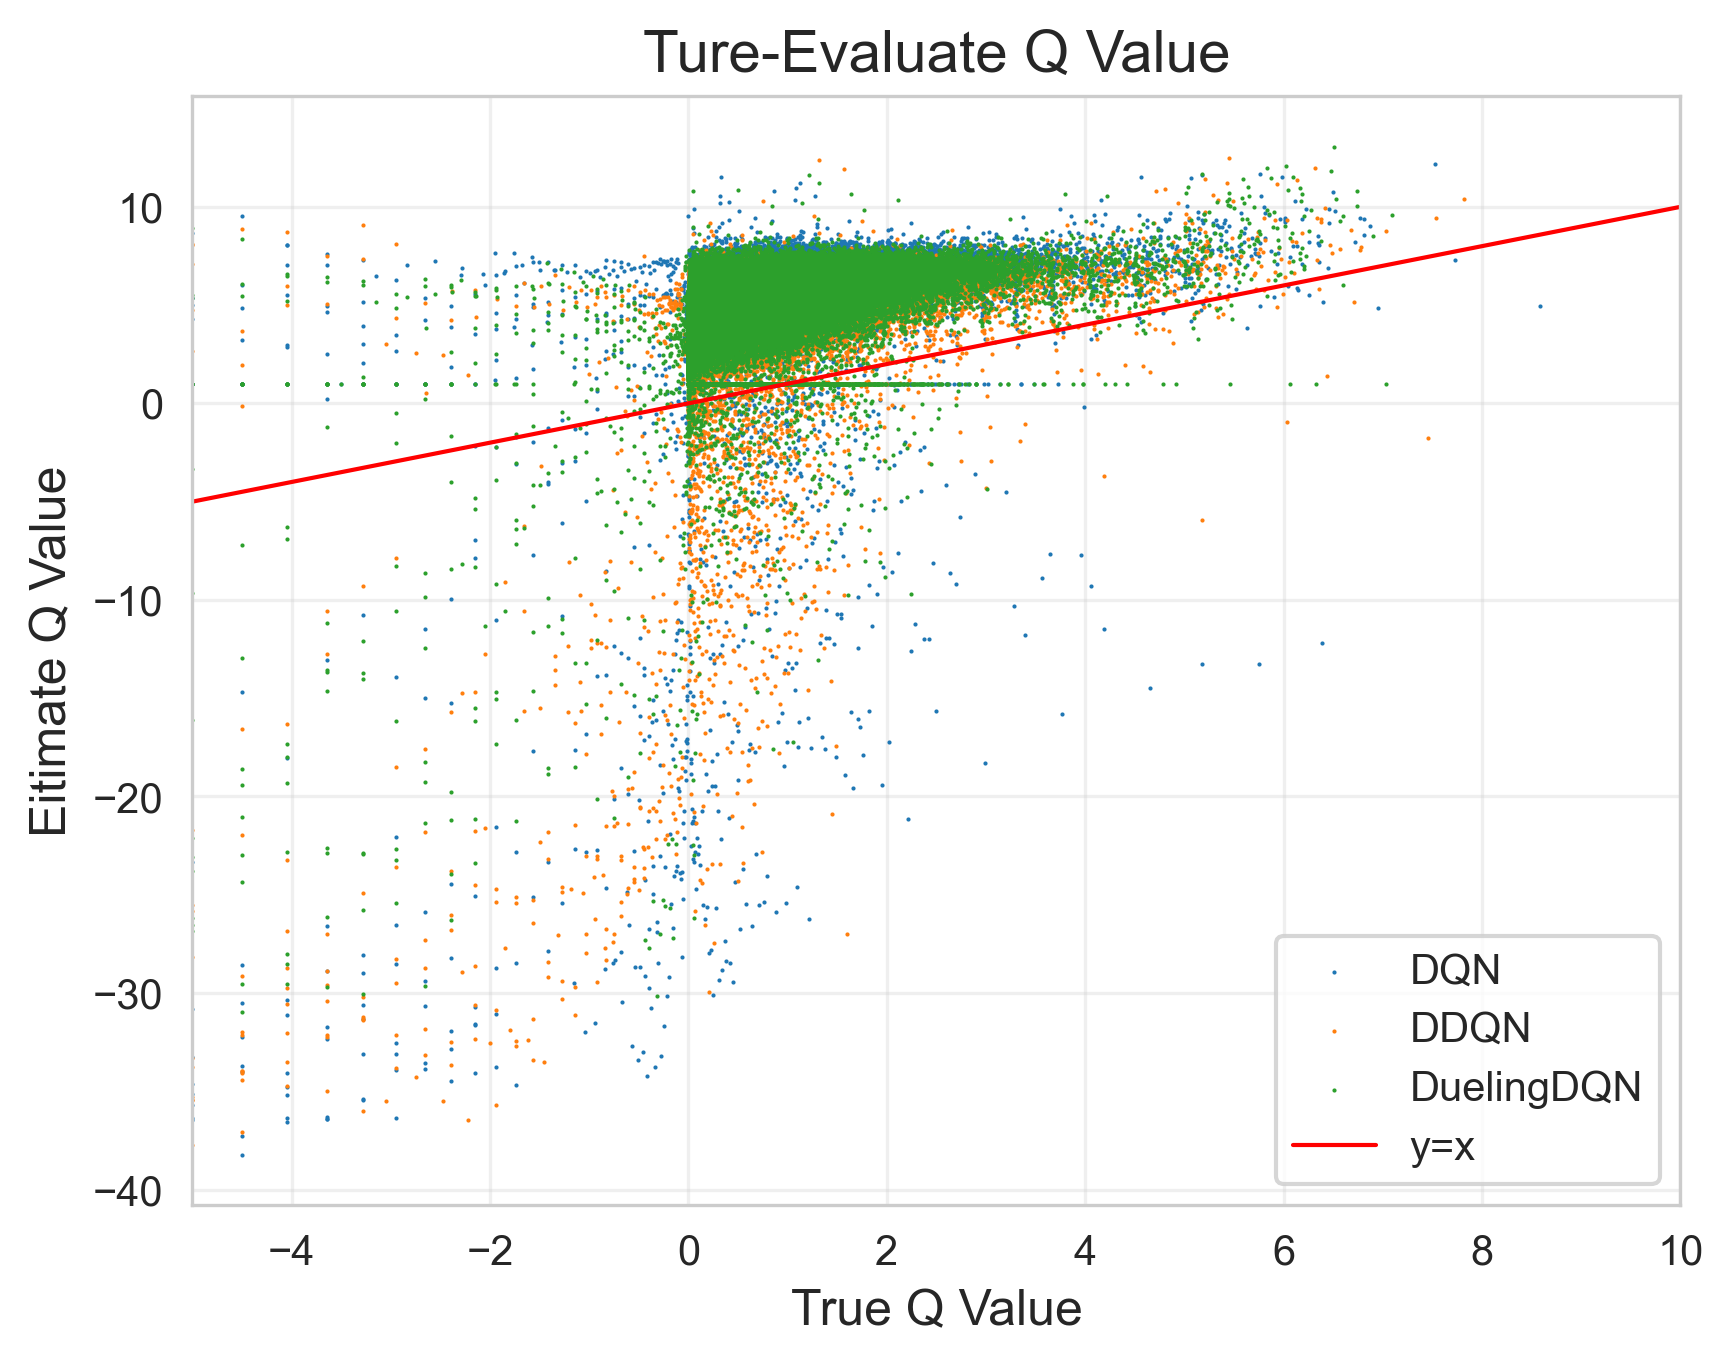

In [66]:
models = ["DQN", "DDQN", "DuelingDQN"]
indicator["DuelingDQN"] = {}
for model in models:
    with open(f'./results/{model}/q_value.txt', 'r') as f:
        lines = f.readlines()
        estimate_q = []
        true_q = []
        for line in lines:
            data = line.strip('\n').split(' ')
            data = [float(s) for s in data]
            estimate_q.append(data[0])
            true_q.append(data[1])
        indicator[model]['estimate_q'] = estimate_q[:50000]
        indicator[model]['true_q'] = true_q[:50000]


for model in models:
    plt.scatter(indicator[model]['true_q'], 
                indicator[model]['estimate_q'],
                s = 1,
                linewidths=0,
                label=model)
x = np.linspace(-5, 10, 100)
y = x
plt.plot(x, y, label='y=x', color='red', linestyle='-', linewidth=1)

plt.title('Ture-Evaluate Q Value')
plt.legend(loc='lower right')
plt.xlabel('True Q Value')
plt.ylabel('Eitimate Q Value')
plt.grid(True, alpha=0.3)
plt.xlim(-5, 10)
plt.savefig('./pictures/03_qvalue.png', dpi=300, bbox_inches='tight')
plt.show()

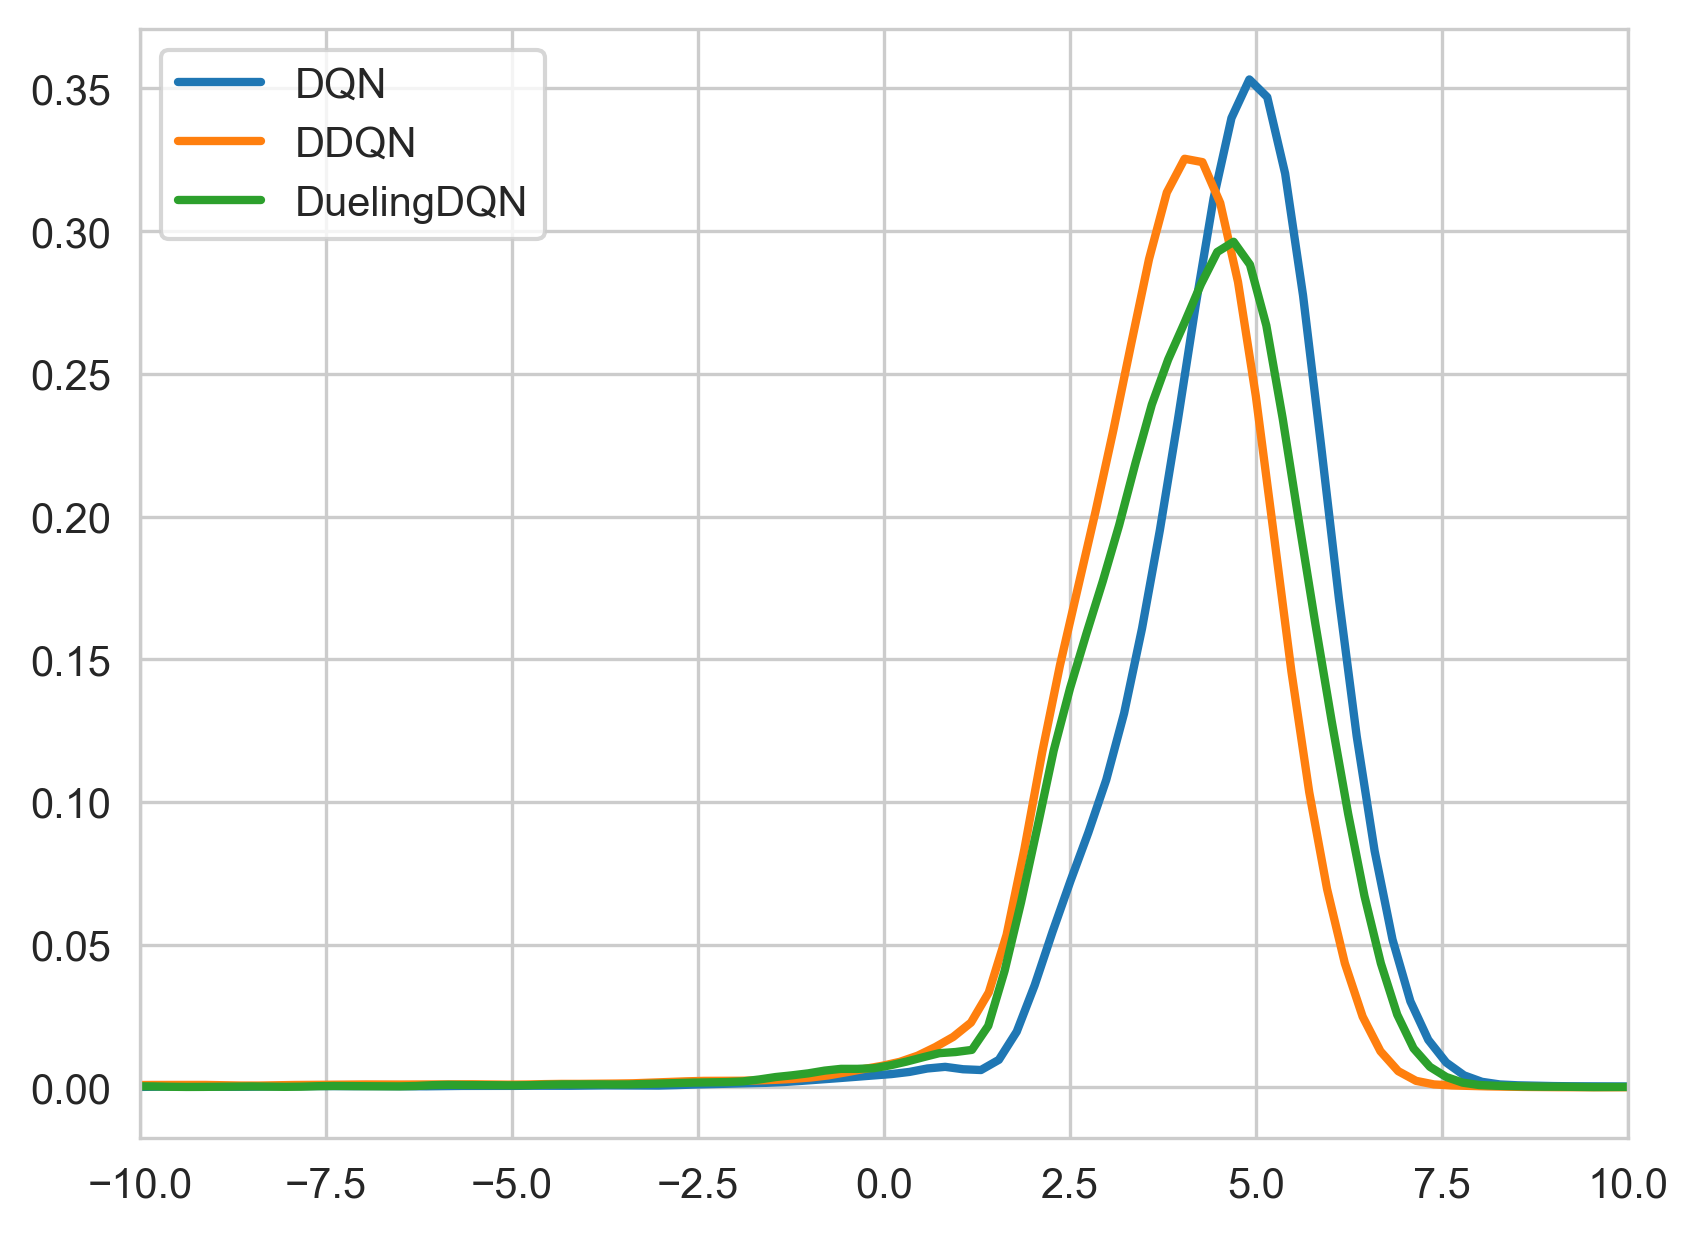

In [68]:
for model in models:
    score = np.array(indicator[model]['estimate_q']) - np.array(indicator[model]['true_q'])
    density = stats.gaussian_kde(score)
    xs = np.linspace(min(score), max(score), 200)
    plt.plot(xs, density(xs), 
             label = f'{model}',
            #  color=colors[model],
             linestyle="-",
             linewidth=2)
plt.xlim(-10, 10)
plt.legend()